In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)
from sklearn.model_selection import (GridSearchCV,
                                     TimeSeriesSplit)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

In [38]:
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Calibri"
plt.style.use("ggplot")
teal = "#00C0D2"
light_blue = "#4251BC"
blue = "#262E6C"
dark_blue = "#111530"
black = "#000000"
cian = "#4AA6EE"

In [11]:
df_full : pd.DataFrame = pd.read_csv('./data/checkpoints/df_full_v1.csv',index_col='Unnamed: 0')
df_full.head(2)

,precipitacao_total,pressao_atmosferica,radiacao_global,temperatura_ar,temperatura_ponto_carvalho,umidade_relativa_ar,vento_direcao,velocidade_vento,id_subsistema,nom_subsistema,val_cargaenergiahomwmed
2012-01-01 00:00:00,0.88,947.22,-2.8518,21.70,19.7,90.25,95.8,1.48,SE,SUDESTE,28212.46
2012-01-01 01:00:00,2.00,947.30,-2.4346,21.24,19.5,92.00,114.0,0.80,SE,SUDESTE,27511.77


In [17]:
## Criando as features de tempo
df_full['Date'] = pd.to_datetime(df_full.index)

df_full["dataref"] = df_full['Date'].dt.strftime("%Y%m%d")
df_full["ano"] = df_full["Date"].dt.year
df_full["mes"] = df_full["Date"].dt.month
df_full["semana"] = df_full["Date"].dt.week
df_full["dia"] = df_full["Date"].dt.day
df_full["dia_semana"] = df_full["Date"].dt.dayofweek
df_full["hora"] = df_full["Date"].dt.hour

df_full.drop(['Date'],axis=1,inplace=True)

df_full.head(2)

C:\Users\augusto.lourencatto\AppData\Local\Temp\ipykernel_13652\785660905.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_full["semana"] = df_full["Date"].dt.week


,precipitacao_total,pressao_atmosferica,radiacao_global,temperatura_ar,temperatura_ponto_carvalho,umidade_relativa_ar,vento_direcao,velocidade_vento,id_subsistema,nom_subsistema,val_cargaenergiahomwmed,date,dataref,ano,mes,semana,dia,dia_semana,hora
2012-01-01 00:00:00,0.88,947.22,-2.8518,21.70,19.7,90.25,95.8,1.48,SE,SUDESTE,28212.46,2012-01-01 00:00:00,20120101,2012,1,52,1,6,0
2012-01-01 01:00:00,2.00,947.30,-2.4346,21.24,19.5,92.00,114.0,0.80,SE,SUDESTE,27511.77,2012-01-01 01:00:00,20120101,2012,1,52,1,6,1


In [45]:
## Marcando o pico de potência 
df_demanda_potencia : pd.DataFrame = df_full.copy()

df_demanda_potencia["max_executado"] = df_demanda_potencia.groupby("dataref")["val_cargaenergiahomwmed"].transform("max")
df_demanda_potencia["pico"] = (df_demanda_potencia["val_cargaenergiahomwmed"] == df_demanda_potencia["max_executado"])
df_demanda_potencia["pico"] = df_demanda_potencia["pico"].astype(int)

df_demanda_potencia.head(2)
df_demanda_potencia[df_demanda_potencia['pico'] == 1].head(2)

,precipitacao_total,pressao_atmosferica,radiacao_global,temperatura_ar,temperatura_ponto_carvalho,umidade_relativa_ar,vento_direcao,velocidade_vento,id_subsistema,nom_subsistema,...,date,dataref,ano,mes,semana,dia,dia_semana,hora,max_executado,pico
2012-01-01 21:00:00,0.72,944.0,212.8652,21.12,18.875,90.00,123.6,1.50,SE,SUDESTE,...,2012-01-01 21:00:00,20120101,2012,1,52,1,6,21,33255.76,1
2012-01-02 21:00:00,0.20,945.3,555.6312,22.98,16.850,69.25,172.0,2.24,SE,SUDESTE,...,2012-01-02 21:00:00,20120102,2012,1,1,2,0,21,36982.45,1


C:\Users\augusto.lourencatto\AppData\Local\Temp\ipykernel_13652\2100764665.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.axvline(pd.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)


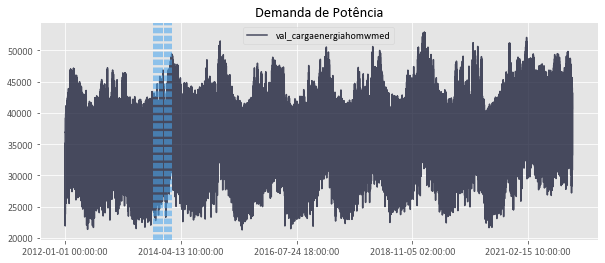

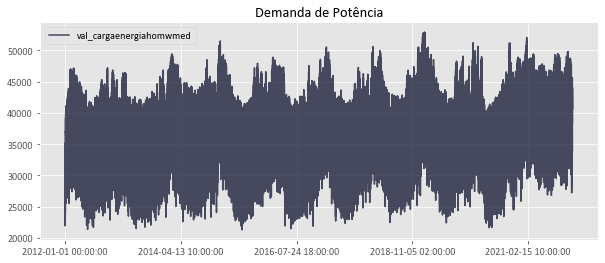

<AxesSubplot:title={'center':'Demanda de Potência 28/04 - 02/05'}>

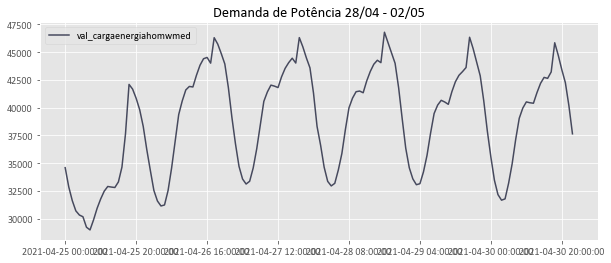

In [27]:
#Plots
ax = df_demanda_potencia.plot(
    y="val_cargaenergiahomwmed", figsize=(10, 4), title="Demanda de Potência", c=dark_blue, alpha=0.75,
)
for y in np.arange(2012, 2021):
    ax.axvline(pd.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)
plt.show()

df_demanda_potencia.loc["2012-01-01":"2021-12-31"].plot(
    y="val_cargaenergiahomwmed",
    figsize=(10, 4),
    title="Demanda de Potência",
    c=dark_blue,
    alpha=0.75,
)
plt.show()

# df_demanda_potencia.loc["2020-01-01":"2021-05-01"].plot(
#     y="val_cargaenergiahomwmed",
#     figsize=(10, 4),
#     title="Demanda de Potência 2020 - 2021 (Efeito Covid 19)",
#     c=dark_blue,
#     alpha=0.75,
# )
# plt.show()

# df_demanda_potencia.loc["2021-03-01":"2021-04-01"].plot(
#     y="val_cargaenergiahomwmed",
#     figsize=(10, 4),
#     title="Demanda de Potência Março 2021",
#     c=dark_blue,
#     alpha=0.75,
# )
# plt.show()

# df_demanda_potencia.loc["2021-04-25":"2021-05-01"].plot(
#     y="val_cargaenergiahomwmed",
#     figsize=(10, 4),
#     title="Demanda de Potência 28/04 - 02/05",
#     c=dark_blue,
#     alpha=0.75,
# )

In [33]:
## Modelando o crescimento básico da demanda
df_demanda_potencia["DATE"] = pd.to_datetime(df_demanda_potencia.index)
df_demanda_potencia["ORDINAL_DATE"] = df_demanda_potencia["DATE"].apply(
    lambda x: time.mktime(x.timetuple())
)

lin_regr = LinearRegression(fit_intercept=True)

x = df_demanda_potencia.dropna(subset=["val_cargaenergiahomwmed", "ORDINAL_DATE"])[
    "ORDINAL_DATE"
].values.reshape(-1, 1)
y = df_demanda_potencia.dropna(subset=["val_cargaenergiahomwmed", "ORDINAL_DATE"])["val_cargaenergiahomwmed"].values.reshape(
    -1, 1
)

lin_regr.fit(x, y)
print("LinReg Slope (per timestep):", lin_regr.coef_[0])
print("LinReg Intercept:", lin_regr.intercept_)
print("LinReg Slope (per month):", lin_regr.coef_[0] * 48 * 30)
print("LinReg Slope (per year):", lin_regr.coef_[0] * 48 * 365)

# df_demanda_potencia.head()

LinReg Slope (per timestep): [9.08748983e-06]
LinReg Intercept: [22834.97189732]
LinReg Slope (per month): [0.01308599]
LinReg Slope (per year): [0.15921282]


C:\Users\augusto.lourencatto\AppData\Local\Temp\ipykernel_13652\1311883653.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.axvline(pd.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)


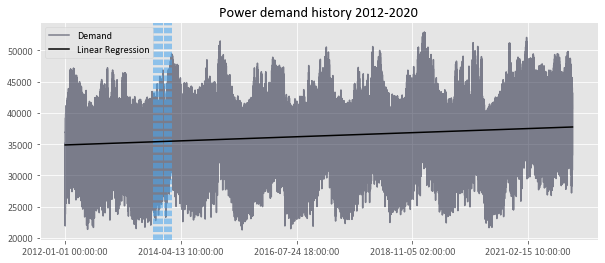

In [35]:
df_demanda_potencia["LINREG"] = lin_regr.predict(
    df_demanda_potencia["ORDINAL_DATE"].values.reshape(-1, 1)
)
ax = df_demanda_potencia.plot(
    y="val_cargaenergiahomwmed",
    figsize=(10, 4),
    title="Power demand history 2012-2020",
    c=dark_blue,
    alpha=0.5,
    label="Demand",
)
for y in np.arange(2012, 2021):
    ax.axvline(pd.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)
df_demanda_potencia.plot(y="LINREG", figsize=(10, 4), c="k", ax=ax, label="Linear Regression")
plt.show()

c:\Users\augusto.lourencatto\Desktop\me\TCC\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribuição de Probabilidade da Demanda ')

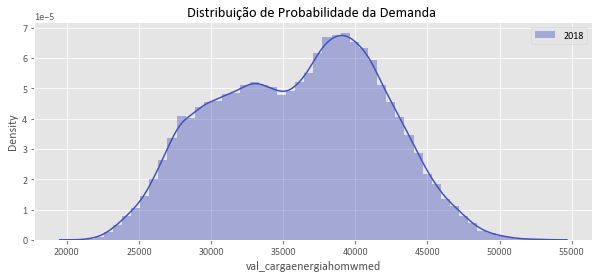

In [39]:
## Analisando a distribuição da demanda
#TODO: Fazer para todos os anos

ax = sns.distplot(
    df_demanda_potencia.loc["2012-01-01":"2021-01-31"]["val_cargaenergiahomwmed"], label="2018", color=light_blue,
)

# sns.distplot(
#     df_demanda_potencia.loc["2019-01-01":"2020-01-01"]["executado"],
#     label="2019",
#     color=blue,
#     ax=ax,
# )
# sns.distplot(
#     df_demanda_potencia.loc["2020-01-01":"2021-01-01"]["executado"],
#     label="2020",
#     color=teal,
#     ax=ax,
# )
# sns.distplot(
#     df_demanda_potencia.loc["2021-01-01":"2021-05-01"]["executado"],
#     label="2021",
#     color=black,
#     ax=ax,
# )
ax.legend()
ax.set_title("Distribuição de Probabilidade da Demanda ")

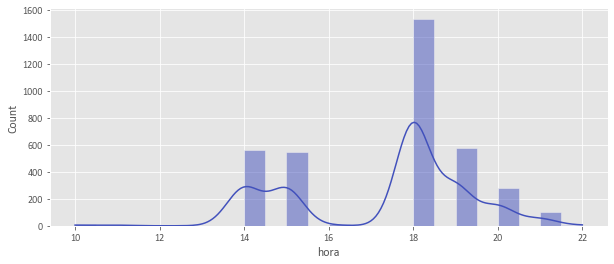

In [47]:
#Como se dá a ocorrência dos picos ao longo dos anos?
#TODO: Fazer para todos os anos
df_demanda_pico = df_demanda_potencia[df_demanda_potencia["pico"] == 1].copy()


ax = sns.histplot(
    df_demanda_pico.loc["2012-01-01":"2021-12-31"]["hora"], label="2018", color=light_blue, kde=True
)
# sns.histplot(
#     df_demanda_pico.loc["2019-01-01":"2020-01-01"]["hora"], label="2019", color=blue, ax=ax,kde=True
# )
# sns.histplot(
#     df_demanda_pico.loc["2020-01-01":"2021-01-01"]["hora"], label="2020", color=teal, ax=ax,kde=True
# )
# sns.histplot(
#     df_demanda_pico.loc["2021-01-01":"2021-05-01"]["hora"], label="2021", color=black, ax=ax,kde=True
# )

# ax.legend()

In [ ]:
# #Plot do primeiro semestre de cada ano
# ax = sns.histplot(
#     df_demanda_pico.loc["2018-01-01":"2018-05-01"]["hora"], label="2018", color=light_blue, kde=True
# )
# sns.histplot(
#     df_demanda_pico.loc["2019-01-01":"2019-05-01"]["hora"], label="2019", color=blue, ax=ax,kde=True
# )
# sns.histplot(
#     df_demanda_pico.loc["2020-01-01":"2020-05-01"]["hora"], label="2020", color=teal, ax=ax,kde=True
# )
# sns.histplot(
#     df_demanda_pico.loc["2021-01-01":"2021-05-01"]["hora"], label="2021", color=black, ax=ax,kde=True
# )

In [ ]:
#TODO: Fazer para os dados de temperatura também